In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import anatools.analysis as ana

from hhdm_analysis.xgb.controllers import XGBLearner, XGBModel
from hhdm_analysis.xgb.utils import model_performance, compute_purity_cutflow, compute_best_thr
from hhdm_analysis.utils import position, signal_label

ana.start()
plt.style.use("default")

# Setup config

In [2]:
period = 'APV_16'
year_style = 2016
dataset_year = "APV_2016"
basedir = '/home/gamoreir/SanDisk/physics/hhdmAnalysis_deepJet_Regions/datasets'

# Setup figure folders
dataset_name = basedir.split('/')[-2]
figures_path = f"./figures/{dataset_name}/{dataset_year}/machine_learning"
Path(figures_path).mkdir(parents=True, exist_ok=True)

# Data folder
data_path = f"./data/{dataset_name}/{dataset_year}"
Path(data_path).mkdir(parents=True, exist_ok=True)

# Setup models folders
models_path = f"./models/{dataset_name}/{dataset_year}"
Path(models_path).mkdir(parents=True, exist_ok=True)

# Read metadata

In [3]:
with open("../metadata.json", "r") as f:
    metadata = json.load(f)

# Read data and model

In [4]:
# model_name = "XGB_Signal_400_100"
# plot_label = signal_label("400", "100")

# model_name = "XGB_Signal_1000_100"
# plot_label = signal_label("1000", "100")

model_name = "XGB_multi_signal"
plot_label ="Multi-signal"

# Train and test data
X_train = pd.read_csv(f"{data_path}/{model_name}-train-data.csv")
X_test = pd.read_csv(f"{data_path}/{model_name}-test-data.csv")
W_train = X_train.pop("modelWeight").values
W_test = X_test.pop("modelWeight").values
Y_train = X_train.pop("Label").values
Y_test = X_test.pop("Label").values
evtWeight_train = X_train.pop("evtWeight").values
evtWeight_test = X_test.pop("evtWeight").values

# Model
features = ["LeadingLep_pt", "LepLep_deltaM", "LepLep_deltaR", "LepLep_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "MET_pt", "MT2LL", "Nbjets", "TrailingLep_pt"]
model = XGBModel(model_fpath=f"{models_path}/{model_name}-clf.model")

# Predict train and test

In [5]:
# Train
Y_pred_train = model.predict(X_train[features], features)
perf_train = model_performance(Y_train, Y_pred_train, n=1000)
ppv_train_cutflow = compute_purity_cutflow(perf_train.threshold, perf_train.fpr, perf_train.tpr, perf_train.ppv, perf_train.acc)
best_train_thr = compute_best_thr(perf_train.threshold, perf_train.tpr, perf_train.ppv)
ppv_train_cutflow.to_csv(f"{models_path}/{model_name}-ppv-train-cutflow.csv", index=False)

# Test
Y_pred_test = model.predict(X_test[features], features)
perf_test = model_performance(Y_test, Y_pred_test, n=1000)
ppv_test_cutflow = compute_purity_cutflow(perf_test.threshold, perf_test.fpr, perf_test.tpr, perf_test.ppv, perf_test.acc)
best_test_thr = compute_best_thr(perf_test.threshold, perf_test.tpr, perf_test.ppv)
ppv_test_cutflow.to_csv(f"{models_path}/{model_name}-ppv-test-cutflow.csv", index=False)

In [6]:
print("Best thr:", best_train_thr)
display(ppv_train_cutflow)

Best thr: 0.983983983983984


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.100000,0.100273,0.023023,0.999245,0.138047,0.213577
1,0.200000,0.200333,0.185185,0.984950,0.622031,0.653860
2,0.300000,0.300244,0.468468,0.964499,0.783898,0.799737
3,0.400000,0.400248,0.750751,0.937818,0.864903,0.871298
4,0.500000,0.500153,0.920921,0.895096,0.914002,0.912344
5,0.600000,0.600304,0.976977,0.828919,0.946941,0.936590
6,0.700000,0.714019,0.991992,0.696120,0.973196,0.948895
7,0.800000,0.866505,0.994995,0.443959,0.993425,0.945234
8,0.900000,0.088947,0.000000,1.000000,0.015317,0.101678
9,0.631091,0.631091,0.983984,0.805301,0.954745,0.941638


In [7]:
print("Best thr:", best_test_thr)
display(ppv_test_cutflow)

Best thr: 0.983983983983984


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.100000,0.100129,0.023023,0.998826,0.137008,0.212595
1,0.200000,0.200209,0.187187,0.980975,0.623254,0.654628
2,0.300000,0.300069,0.472472,0.959844,0.784756,0.800112
3,0.400000,0.400107,0.753754,0.931842,0.865681,0.871484
4,0.500000,0.500379,0.921922,0.889407,0.914623,0.912412
5,0.600000,0.600055,0.976977,0.824770,0.947151,0.936417
6,0.700000,0.714276,0.991992,0.690698,0.973438,0.948640
7,0.800000,0.867482,0.994995,0.443236,0.993491,0.945230
8,0.900000,0.088932,0.000000,1.000000,0.015100,0.101482
9,0.630483,0.630483,0.983984,0.800981,0.954868,0.941372


# Prepare data to plot discriminant

In [8]:
scale_factor = 10**6

X_train["XGB_score"] = Y_pred_train
X_test["XGB_score"] = Y_pred_test
X_train["modelWeight"] = W_train/scale_factor
X_test["modelWeight"] = W_test/scale_factor
X_train["Label"] = Y_train
X_test["Label"] = Y_test
X_train["evtWeight"] = evtWeight_train
X_test["evtWeight"] = evtWeight_test

# Plot discriminant using modelWeight

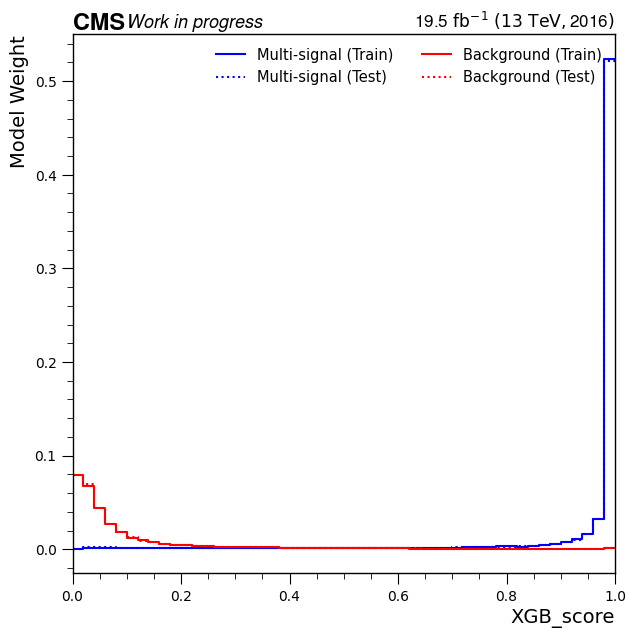

In [9]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ana.step_plot(ax1, "XGB_score", X_train[X_train.Label == 1], label=f"{plot_label} (Train)", color="blue", weight="modelWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "XGB_score", X_test[X_test.Label == 1], label=f"{plot_label} (Test)", color="blue", weight="modelWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")
ana.step_plot(ax1, "XGB_score", X_train[X_train.Label == 0], label="Background (Train)", color="red", weight="modelWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "XGB_score", X_test[X_test.Label == 0], label="Background (Test)", color="red", weight="modelWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")

ana.labels(ax1, ylabel="Model Weight", xlabel="XGB_score")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=2, #ylim=[0, 1]
)
plt.savefig(f"{figures_path}/XGB_score-modelWeight-{model_name}.png", dpi=200, facecolor='white')
plt.show()

# Plot discriminant using evtWeight

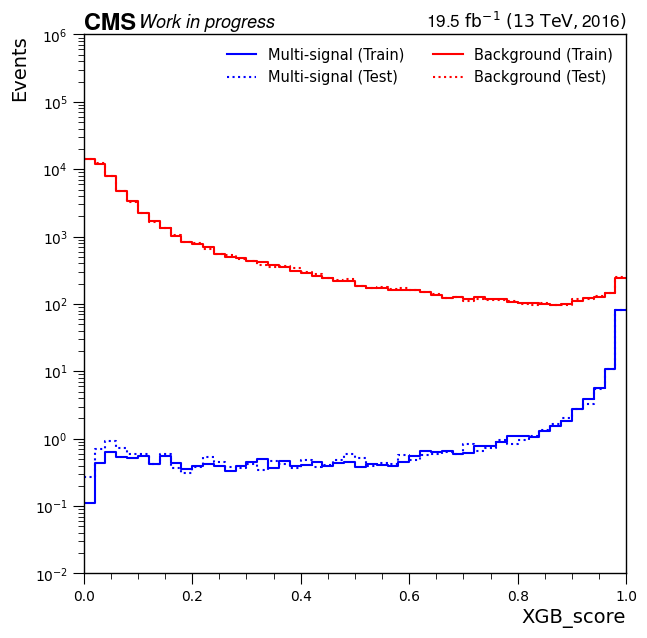

In [10]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ana.step_plot(ax1, "XGB_score", X_train[X_train.Label == 1], label=f"{plot_label} (Train)", color="blue", weight="evtWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "XGB_score", X_test[X_test.Label == 1], label=f"{plot_label} (Test)", color="blue", weight="evtWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")
ana.step_plot(ax1, "XGB_score", X_train[X_train.Label == 0], label="Background (Train)", color="red", weight="evtWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "XGB_score", X_test[X_test.Label == 0], label="Background (Test)", color="red", weight="evtWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")

ana.labels(ax1, ylabel="Events", xlabel="XGB_score")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, ylim=[1e-2, 1e6]
)
plt.savefig(f"{figures_path}/XGB_score-evtWeight-{model_name}.png", dpi=200, facecolor='white')
plt.show()